# Project Recommendation System

This notebook implements a recommendation system for Lovable projects using:
1. Semantic search with FAISS to find similar projects
2. ML-based ranking to prioritize projects based on engagement metrics
3. Cold-start recommendation strategy for new projects

Let's get started!

## 1. Setup and Data Loading

### Memory Management

This notebook involves working with vector embeddings and machine learning models that can use significant memory. We'll use Python's garbage collector (`gc`) at key points to free up memory and prevent kernel crashes.

In [1]:
# Install required packages
!pip install faiss-cpu numpy pandas scikit-learn sentence-transformers lightgbm matplotlib


[notice] A new release of pip is available: 23.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import json
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import gc  # Import garbage collector for memory management

In [2]:
# Load the enriched projects data
with open('enriched_data/enriched_projects.json', 'r') as file:
    projects_data = json.load(file)

# Convert to DataFrame for easier manipulation
projects_df = pd.DataFrame(projects_data)

# Display the first few projects
projects_df.head()

,id,title,description,link,remixes,image_url,author_img,scraped_at,full_description,technologies,image_analysis,text_features,scraped_date,popularity_score,screenshot_description
0,c97c0a8e-4d68-4bc4-9fe0-c26ee71c3856,fancy-saas-splash,A modern landing page template for SaaS produc...,https://lovable.dev/projects/c97c0a8e-4d68-4bc...,"{'count': 35, 'text': '35 Remixes'}",https://storage.googleapis.com/gpt-engineer-sc...,https://lh3.googleusercontent.com/a/ACg8ocKpsv...,2025-05-21T18:49:16.306404,,[],"{'dimensions': {'width': 1920, 'height': 1979,...","{'word_count': 3, 'sentiment': {'polarity': 0....",2025-05-21,175,NaN
1,65e44bd6-84d0-4f67-a532-c7f2a71f7d46,valk-life,A lifestyle application or website dedicated t...,https://lovable.dev/projects/65e44bd6-84d0-4f6...,"{'count': 40, 'text': '40 Remixes'}",https://storage.googleapis.com/gpt-engineer-sc...,https://avatars.githubusercontent.com/u/441197...,2025-05-21T18:49:16.337169,,[],"{'dimensions': {'width': 1920, 'height': 2935,...","{'word_count': 2, 'sentiment': {'polarity': 0....",2025-05-21,200,NaN
2,6fb25ca9-773a-4499-aa1a-2c5df274248d,monster-landing-magic,An eye-catching landing page template with bol...,https://lovable.dev/projects/6fb25ca9-773a-449...,"{'count': 47, 'text': '47 Remixes'}",https://storage.googleapis.com/gpt-engineer-sc...,https://lh3.googleusercontent.com/a/ACg8ocKpsv...,2025-05-21T18:49:16.388370,,[],"{'dimensions': {'width': 1920, 'height': 2655,...","{'word_count': 3, 'sentiment': {'polarity': 0....",2025-05-21,235,NaN
3,156c4586-27b3-4c80-992f-6996d77bfbc1,future-real-estate-site,A forward-thinking real estate platform showca...,https://lovable.dev/projects/156c4586-27b3-4c8...,"{'count': 48, 'text': '48 Remixes'}",https://storage.googleapis.com/gpt-engineer-sc...,https://lh3.googleusercontent.com/a/ACg8ocKBv6...,2025-05-21T18:49:16.422113,,[],"{'dimensions': {'width': 1920, 'height': 2126,...","{'word_count': 4, 'sentiment': {'polarity': 0....",2025-05-21,240,NaN
4,f60ff3fb-aac0-4b5b-a359-c84636b03332,turn-based-chess-duel,An interactive chess game application featurin...,https://lovable.dev/projects/f60ff3fb-aac0-4b5...,"{'count': 52, 'text': '52 Remixes'}",https://storage.googleapis.com/gpt-engineer-sc...,https://lh3.googleusercontent.com/a/ACg8ocJgj-...,2025-05-21T18:49:16.456430,,[],"{'dimensions': {'width': 1920, 'height': 1080,...","{'word_count': 4, 'sentiment': {'polarity': 0....",2025-05-21,260,NaN


In [3]:
# Examine the data
print(f"Total number of projects: {len(projects_df)}")
print(f"Columns available: {projects_df.columns.tolist()}")

# Check for missing values
print("\nMissing values by column:")
print(projects_df.isnull().sum())

Total number of projects: 32
Columns available: ['id', 'title', 'description', 'link', 'remixes', 'image_url', 'author_img', 'scraped_at', 'full_description', 'technologies', 'image_analysis', 'text_features', 'scraped_date', 'popularity_score', 'screenshot_description']

Missing values by column:
id                         0
title                      0
description                0
link                       0
remixes                    0
image_url                  0
author_img                 0
scraped_at                 0
full_description          26
technologies              26
image_analysis             0
text_features              0
scraped_date               0
popularity_score           0
screenshot_description    31
dtype: int64


## 2. Semantic Search with FAISS

We'll create embeddings for each project based on its description and title, then build a FAISS index to enable fast similarity search.

In [4]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Create a function to generate text for embedding
def create_embedding_text(row):
    text = f"Title: {row['title']}. "
    text += f"Description: {row['description']}. "
    
    # Add project category if available
    if 'text_features' in row and 'project_category' in row['text_features']:
        text += f"Category: {row['text_features']['project_category']}. "
    
    # Add keywords if available
    if 'text_features' in row and 'keywords' in row['text_features']:
        text += f"Keywords: {', '.join(row['text_features']['keywords'])}."
    
    return text

In [6]:
# Generate text for each project
projects_df['embedding_text'] = projects_df.apply(create_embedding_text, axis=1)

# Preview the text we'll use for embeddings
print(projects_df['embedding_text'].iloc[0])

Title: fancy-saas-splash. Description: A modern landing page template for SaaS products featuring sleek design elements and engaging visual splash effects.. Category: landing_page. Keywords: fancy, saas, splash.


In [7]:
# Generate embeddings for all projects
project_embeddings = model.encode(projects_df['embedding_text'].tolist(), show_progress_bar=True)

# Display shape and sample of embeddings
print(f"Embedding shape: {project_embeddings.shape}")
print(f"Sample embedding (first 5 dimensions): {project_embeddings[0][:5]}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding shape: (32, 384)
Sample embedding (first 5 dimensions): [-0.0309571   0.01860341  0.04708434  0.00311612  0.07348949]


In [8]:
# Force garbage collection to free memory
gc.collect()

104

In [9]:
# Set up FAISS index
dimension = project_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # Using L2 distance for similarity

# Add the project embeddings to the index
index.add(project_embeddings)

# Verify the index size
print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 32


In [10]:
# Function to get semantically similar projects
def get_similar_projects(query_text, top_k=5):
    # Convert query to embedding
    query_embedding = model.encode([query_text])
    
    # Search for similar projects in the FAISS index
    distances, indices = index.search(query_embedding, top_k)
    
    # Get the similar projects
    similar_projects = projects_df.iloc[indices[0]]
    
    # Add distance information
    similar_projects = similar_projects.copy()
    similar_projects['distance'] = distances[0]
    
    return similar_projects[['id', 'title', 'description', 'distance', 'remixes']]

In [11]:
# Test the semantic search with a sample query
query = "I need a landing page for my SaaS product"
similar_projects = get_similar_projects(query, top_k=5)
print(f"Query: '{query}'\n")
similar_projects

Query: 'I need a landing page for my SaaS product'



,id,title,description,distance,remixes
0,c97c0a8e-4d68-4bc4-9fe0-c26ee71c3856,fancy-saas-splash,A modern landing page template for SaaS produc...,0.907642,"{'count': 35, 'text': '35 Remixes'}"
2,6fb25ca9-773a-4499-aa1a-2c5df274248d,monster-landing-magic,An eye-catching landing page template with bol...,1.123671,"{'count': 47, 'text': '47 Remixes'}"
19,84322c50-98b7-4990-ba4e-2545accf5d91,landing-simulator-sorcery,A landing page creation tool with magical drag...,1.167778,"{'count': 1115, 'text': '1115 Remixes'}"
27,32740053-d4a5-474d-90a4-a52ce5eabadc,lovable-product-grove,An e-commerce platform showcasing a curated co...,1.370921,"{'count': 1, 'text': '1 Remix'}"
9,721b7097-37cd-4dc4-8946-0910b3ea8bc7,agri-dom,An agricultural domain management system for f...,1.438300,"{'count': 1996, 'text': '1996 Remixes'}"


## 3. Machine Learning Ranking Model

Now let's create a model that can re-rank the search results based on engagement metrics like remix count and popularity scores.

In [12]:
# Prepare features for ranking model
def extract_ranking_features(df):
    features = pd.DataFrame()
    
    # Extract engagement metrics
    features['remix_count'] = df['remixes'].apply(lambda x: x['count'] if isinstance(x, dict) and 'count' in x else 0)
    features['popularity_score'] = df['popularity_score']
    
    # Normalize using Min-Max scaling
    scaler = MinMaxScaler()
    features[['remix_count_norm', 'popularity_score_norm']] = scaler.fit_transform(features[['remix_count', 'popularity_score']])
    
    return features

In [13]:
# Extract features for all projects
ranking_features = extract_ranking_features(projects_df)

# Add semantic_distance as a feature for the ranking model
# Note: In a real-world scenario, this would be filled in during search time
ranking_features['semantic_distance'] = 0.0  

# Show feature statistics
ranking_features.describe()

,remix_count,popularity_score,remix_count_norm,popularity_score_norm,semantic_distance
count,32.000000,32.000000,32.000000,32.000000,32.0
mean,453.750000,2268.750000,0.192414,0.192414,0.0
std,658.601255,3293.006274,0.279899,0.279899,0.0
min,1.000000,5.000000,0.000000,0.000000,0.0
25%,22.500000,112.500000,0.009137,0.009137,0.0
50%,69.500000,347.500000,0.029112,0.029112,0.0
75%,710.750000,3553.750000,0.301636,0.301636,0.0
max,2354.000000,11770.000000,1.000000,1.000000,0.0


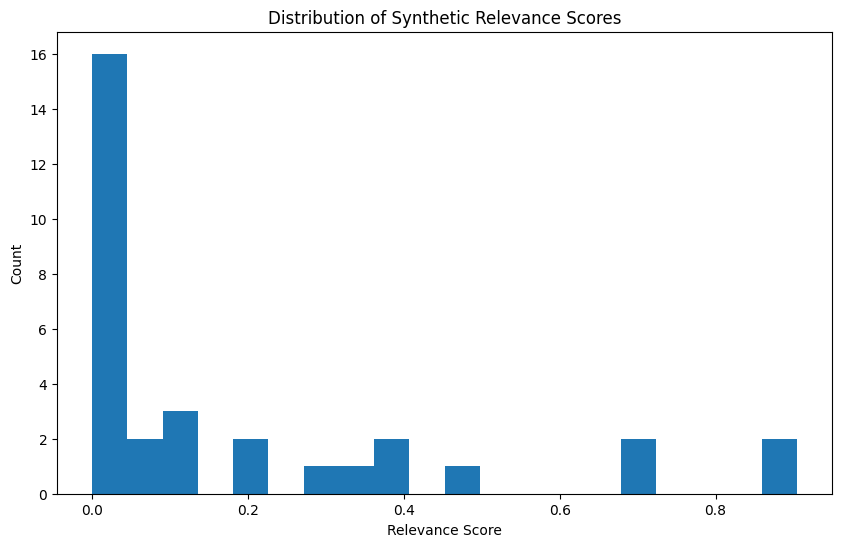

In [14]:
# Create a synthetic dataset for training the ranking model
# In a real application, you would use real user interactions/click data

# Let's create a synthetic relevance score based on remix count and popularity
ranking_features['relevance'] = (ranking_features['remix_count_norm'] * 0.7 + 
                               ranking_features['popularity_score_norm'] * 0.3)

# Add some noise to make it more realistic
np.random.seed(42)
ranking_features['relevance'] = ranking_features['relevance'] + np.random.normal(0, 0.05, len(ranking_features))

# Ensure relevance is between 0 and 1
ranking_features['relevance'] = np.clip(ranking_features['relevance'], 0, 1)

# Plot the distribution of the relevance scores
plt.figure(figsize=(10, 6))
plt.hist(ranking_features['relevance'], bins=20)
plt.title('Distribution of Synthetic Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Count')
plt.show()

In [15]:
# Free memory after model training
gc.collect()

4509

In [16]:
# Prepare data for the ranking model
X = ranking_features[['remix_count_norm', 'popularity_score_norm', 'semantic_distance']]
y = ranking_features['relevance']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a LightGBM ranking model
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Reduced from 31 for small dataset
    'min_data_in_leaf': 1,  # Reduced from 20 for small dataset
    'min_sum_hessian_in_leaf': 1e-3,  # Added for small dataset
    'num_iterations': 30  # Reduced iteration count
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data]
)

In [ ]:
# Free memory after model training
gc.collect()

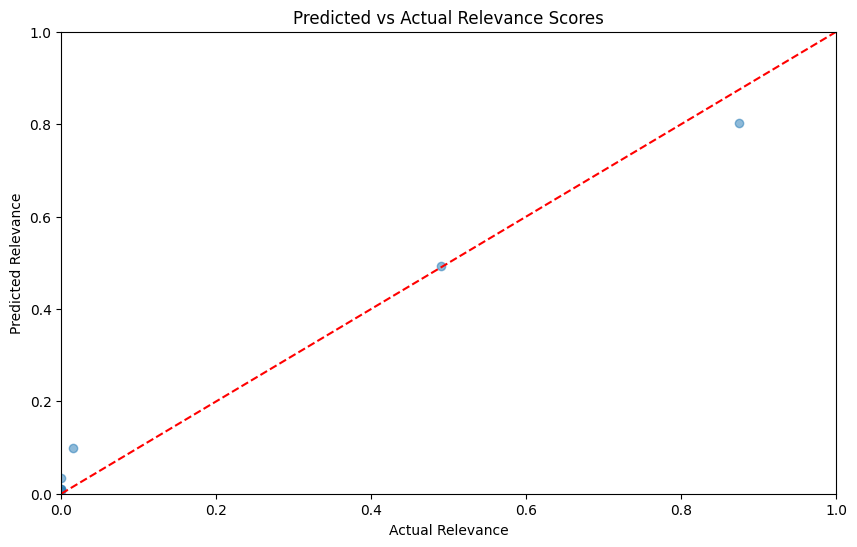

In [19]:
# Evaluate the model on test data
y_pred = model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Predicted vs Actual Relevance Scores')
plt.xlabel('Actual Relevance')
plt.ylabel('Predicted Relevance')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 4. Combined Recommendation Function

Now let's create a function that combines semantic search with ranking.

In [ ]:
def recommend_projects(query, k=5, initial_candidates=15):
    # Get more candidates than we need for re-ranking
    candidates = get_similar_projects(query, top_k=initial_candidates)
    
    # Extract features for ranking
    features = extract_ranking_features(candidates)
    
    # Add semantic distance as a feature
    features['semantic_distance'] = candidates['distance'].values
    # Normalize semantic distance (lower is better, so we invert it after scaling)
    max_dist = features['semantic_distance'].max()
    min_dist = features['semantic_distance'].min()
    if max_dist > min_dist:
        features['semantic_distance'] = 1 - ((features['semantic_distance'] - min_dist) / (max_dist - min_dist))
    else:
        features['semantic_distance'] = 1.0
    
    # Prepare features for the ranking model
    X_rank = features[['remix_count_norm', 'popularity_score_norm', 'semantic_distance']]
    
    # Predict relevance scores
    relevance_scores = model.predict(X_rank)
    
    # Add relevance scores to the results
    candidates['relevance_score'] = relevance_scores
    
    # Sort by relevance score
    ranked_results = candidates.sort_values(by='relevance_score', ascending=False)
    
    # Return top k results
    return ranked_results.head(k)[['id', 'title', 'description', 'distance', 'remixes', 'relevance_score']]

In [ ]:
# Test the combined recommendation function
query = "I need a landing page for my SaaS product"
recommended_projects = recommend_projects(query)
print(f"Query: '{query}'\n")
recommended_projects

## 5. Cold Start Recommendation

Now let's implement a strategy to recommend new projects that have few or no remixes but might be a good fit.

In [ ]:
# Define new projects as those with less than 10 remixes
new_projects = projects_df[projects_df['remixes'].apply(lambda x: x['count'] if isinstance(x, dict) and 'count' in x else 0) < 10]
print(f"Number of new projects: {len(new_projects)}")

In [ ]:
def recommend_new_projects(query, k=3, diversity_weight=0.2):
    # Filter to only include new projects
    new_project_embeddings = project_embeddings[projects_df['remixes'].apply(
        lambda x: x['count'] if isinstance(x, dict) and 'count' in x else 0) < 10]
    
    # Get indices of new projects
    new_project_indices = projects_df.index[projects_df['remixes'].apply(
        lambda x: x['count'] if isinstance(x, dict) and 'count' in x else 0) < 10].tolist()
    
    if len(new_project_indices) == 0:
        return pd.DataFrame(columns=['id', 'title', 'description', 'distance', 'remixes'])
    
    # Create a FAISS index for new projects only
    dimension = new_project_embeddings.shape[1]
    new_projects_index = faiss.IndexFlatL2(dimension)
    new_projects_index.add(new_project_embeddings)
    
    # Convert query to embedding
    query_embedding = model.encode([query])
    
    # Search for similar new projects
    distances, local_indices = new_projects_index.search(query_embedding, k*2)  # Get more candidates
    
    # Convert local indices to global indices
    global_indices = [new_project_indices[i] for i in local_indices[0]]
    
    # Get the candidate projects
    candidates = projects_df.iloc[global_indices].copy()
    candidates['distance'] = distances[0]
    
    # Calculate diversity score based on uniqueness of project categories
    if len(candidates) > 0 and 'text_features' in candidates.columns:
        # Extract categories if they exist
        categories = candidates['text_features'].apply(
            lambda x: x.get('project_category', 'unknown') if isinstance(x, dict) else 'unknown')
        
        # Count occurrences of each category
        category_counts = categories.value_counts()
        
        # Calculate diversity score (lower count = more unique = higher score)
        candidates['diversity_score'] = categories.apply(lambda x: 1.0/category_counts[x])
    else:
        candidates['diversity_score'] = 1.0
    
    # Normalize distances (lower is better, so we invert it after scaling)
    max_dist = candidates['distance'].max()
    min_dist = candidates['distance'].min()
    if max_dist > min_dist:
        candidates['distance_norm'] = 1 - ((candidates['distance'] - min_dist) / (max_dist - min_dist))
    else:
        candidates['distance_norm'] = 1.0
    
    # Combined score: relevance and diversity
    candidates['combined_score'] = (1 - diversity_weight) * candidates['distance_norm'] + \
                                   diversity_weight * candidates['diversity_score']
    
    # Sort by combined score
    candidates = candidates.sort_values('combined_score', ascending=False)
    
    return candidates.head(k)[['id', 'title', 'description', 'distance', 'remixes', 'combined_score']]

In [ ]:
# Test the new project recommendation function
query = "I need a landing page for my SaaS product"
new_project_recommendations = recommend_new_projects(query)
print(f"Query: '{query}'\n")
new_project_recommendations

## 6. Complete Recommendation Pipeline

Now let's combine everything into a complete recommendation pipeline.

In [ ]:
def get_project_recommendations(query, established_count=5, new_count=2):
    print(f"\n===== Recommendations for: '{query}' =====\n")
    
    # Get recommendations for established projects
    print(f"Top {established_count} established projects:")
    established_recommendations = recommend_projects(query, k=established_count)
    display(established_recommendations)
    
    # Get recommendations for new projects
    print(f"\nTop {new_count} promising new projects:")
    new_recommendations = recommend_new_projects(query, k=new_count)
    display(new_recommendations)

In [ ]:
# Test with different queries
queries = [
    "I need a landing page for my SaaS product",
    "Looking for a tool to visualize music",
    "I want to build a chess game",
    "Need a dashboard for food tracking",
    "AI tool that can adapt to my thinking"
]

for query in queries:
    get_project_recommendations(query)

In [ ]:
# Free memory by garbage collecting
print("Cleaning up memory...")
gc.collect()
print("Done.")

## 7. Save the Models

Let's save our models for future use.

In [ ]:
# Make sure the models directory exists
if not os.path.exists('models'):
    os.makedirs('models')

# Save FAISS index
faiss.write_index(index, 'models/project_search_index.faiss')

# Save the LightGBM ranking model
model.save_model('models/ranking_model.txt')

# Save project information and embeddings for future use
np.save('models/project_embeddings.npy', project_embeddings)
projects_df[['id', 'title', 'description', 'remixes', 'popularity_score']].to_csv('models/project_metadata.csv', index=False)

## 8. Conclusion

In this notebook, we've created a complete recommendation system that:

1. Uses semantic search to find projects similar to the user's query
2. Re-ranks the results based on engagement metrics using a machine learning model
3. Recommends promising new projects with few remixes

This system combines content-based and popularity-based recommendation approaches to deliver the most relevant projects to users while still surfacing promising new content. It could be improved with:

- Real user feedback/click data for training the ranking model
- Personalization based on user preferences and history
- A/B testing different ranking strategies
- Periodic retraining of models as new projects are added and engagement patterns change